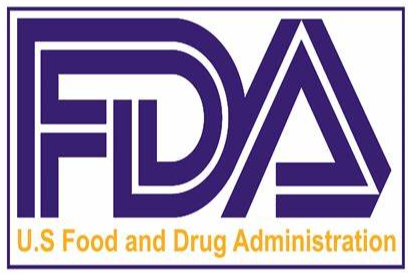

# National Drug Code Hyperlink Prediction by NetAurHPD
This dataset consists of the pharmaceutical classes used to classify drugs in the National Drug Code Directory maintained by the Food and Drug Administration. The original data was downloaded from https://www.fda.gov/Drugs/InformationOnDrugs/ucm142438.htm.

### Data
Each simplex corresponds to an NDC code for a drug, where the nodes are the classes applied to the drug. Note that the same drug substance can have more than one NDC code. For example, different dosages of the same drug may result in multiple NDC codes. The data stpred in two files:

- nverts.txt -> [2, 3, 2, 2, 2,...]

- simplices.txt -> [4, 1, 117, 129, 1, 51, 1,...]

**Meaning**:

Hyperlink 1 = {4,1}

Hyperlink 2 = {117,129,1}

Hyperlink 3 = {51,1}

In [1]:
import sys
import os

In [2]:
sys.path.append(os.path.abspath("../..")) 

In [4]:
from Examples.data_preprocess import data_preprocess, create_train_and_test_sets
from NetAurHPD.predict_by_M5 import predict
from NetAurHPD.network_auralization import network_auralization_from_graph
from NetAurHPD.hyperlinks_waveforms import nodes_to_hyperlink
from Examples.utils import clique_expansion_transformation, negative_sampling, save_hyperlinks_with_label
import torch

Data files path

In [5]:
nodes_data_dir = "ndc_data/NDC-classes-simplices.txt"
groups_size_data_dir = "ndc_data/NDC-classes-nverts.txt"

Load data and transform into hypergraph

In [6]:
unique_hyperlink_dict, nodes = data_preprocess(nodes_data_dir, groups_size_data_dir)

Number of hyperlinks: 46283


Save positive hyperlinks with positive label

In [7]:
positive_hyperlink_dict = save_hyperlinks_with_label(unique_hyperlink_dict)

Negative sampling - create negative hyperlinks examples

In [8]:
negative_hyperlink_dict = negative_sampling(nodes,unique_hyperlink_dict)

Create train and test sets

In [9]:
train_positive_hyperlink_dict, train_hyperlink_dict, y_train, test_hyperlink_dict, y_test = create_train_and_test_sets(positive_hyperlink_dict, negative_hyperlink_dict)

Train positive hyperlinks: 628
Train negative hyperlinks: 628
Test positive hyperlinks: 419
Test negative hyperlinks: 419


Present the Hypergraph as Clique expansion graph

Nodes: 1149
Edges: 4692
HyperLinks: 628


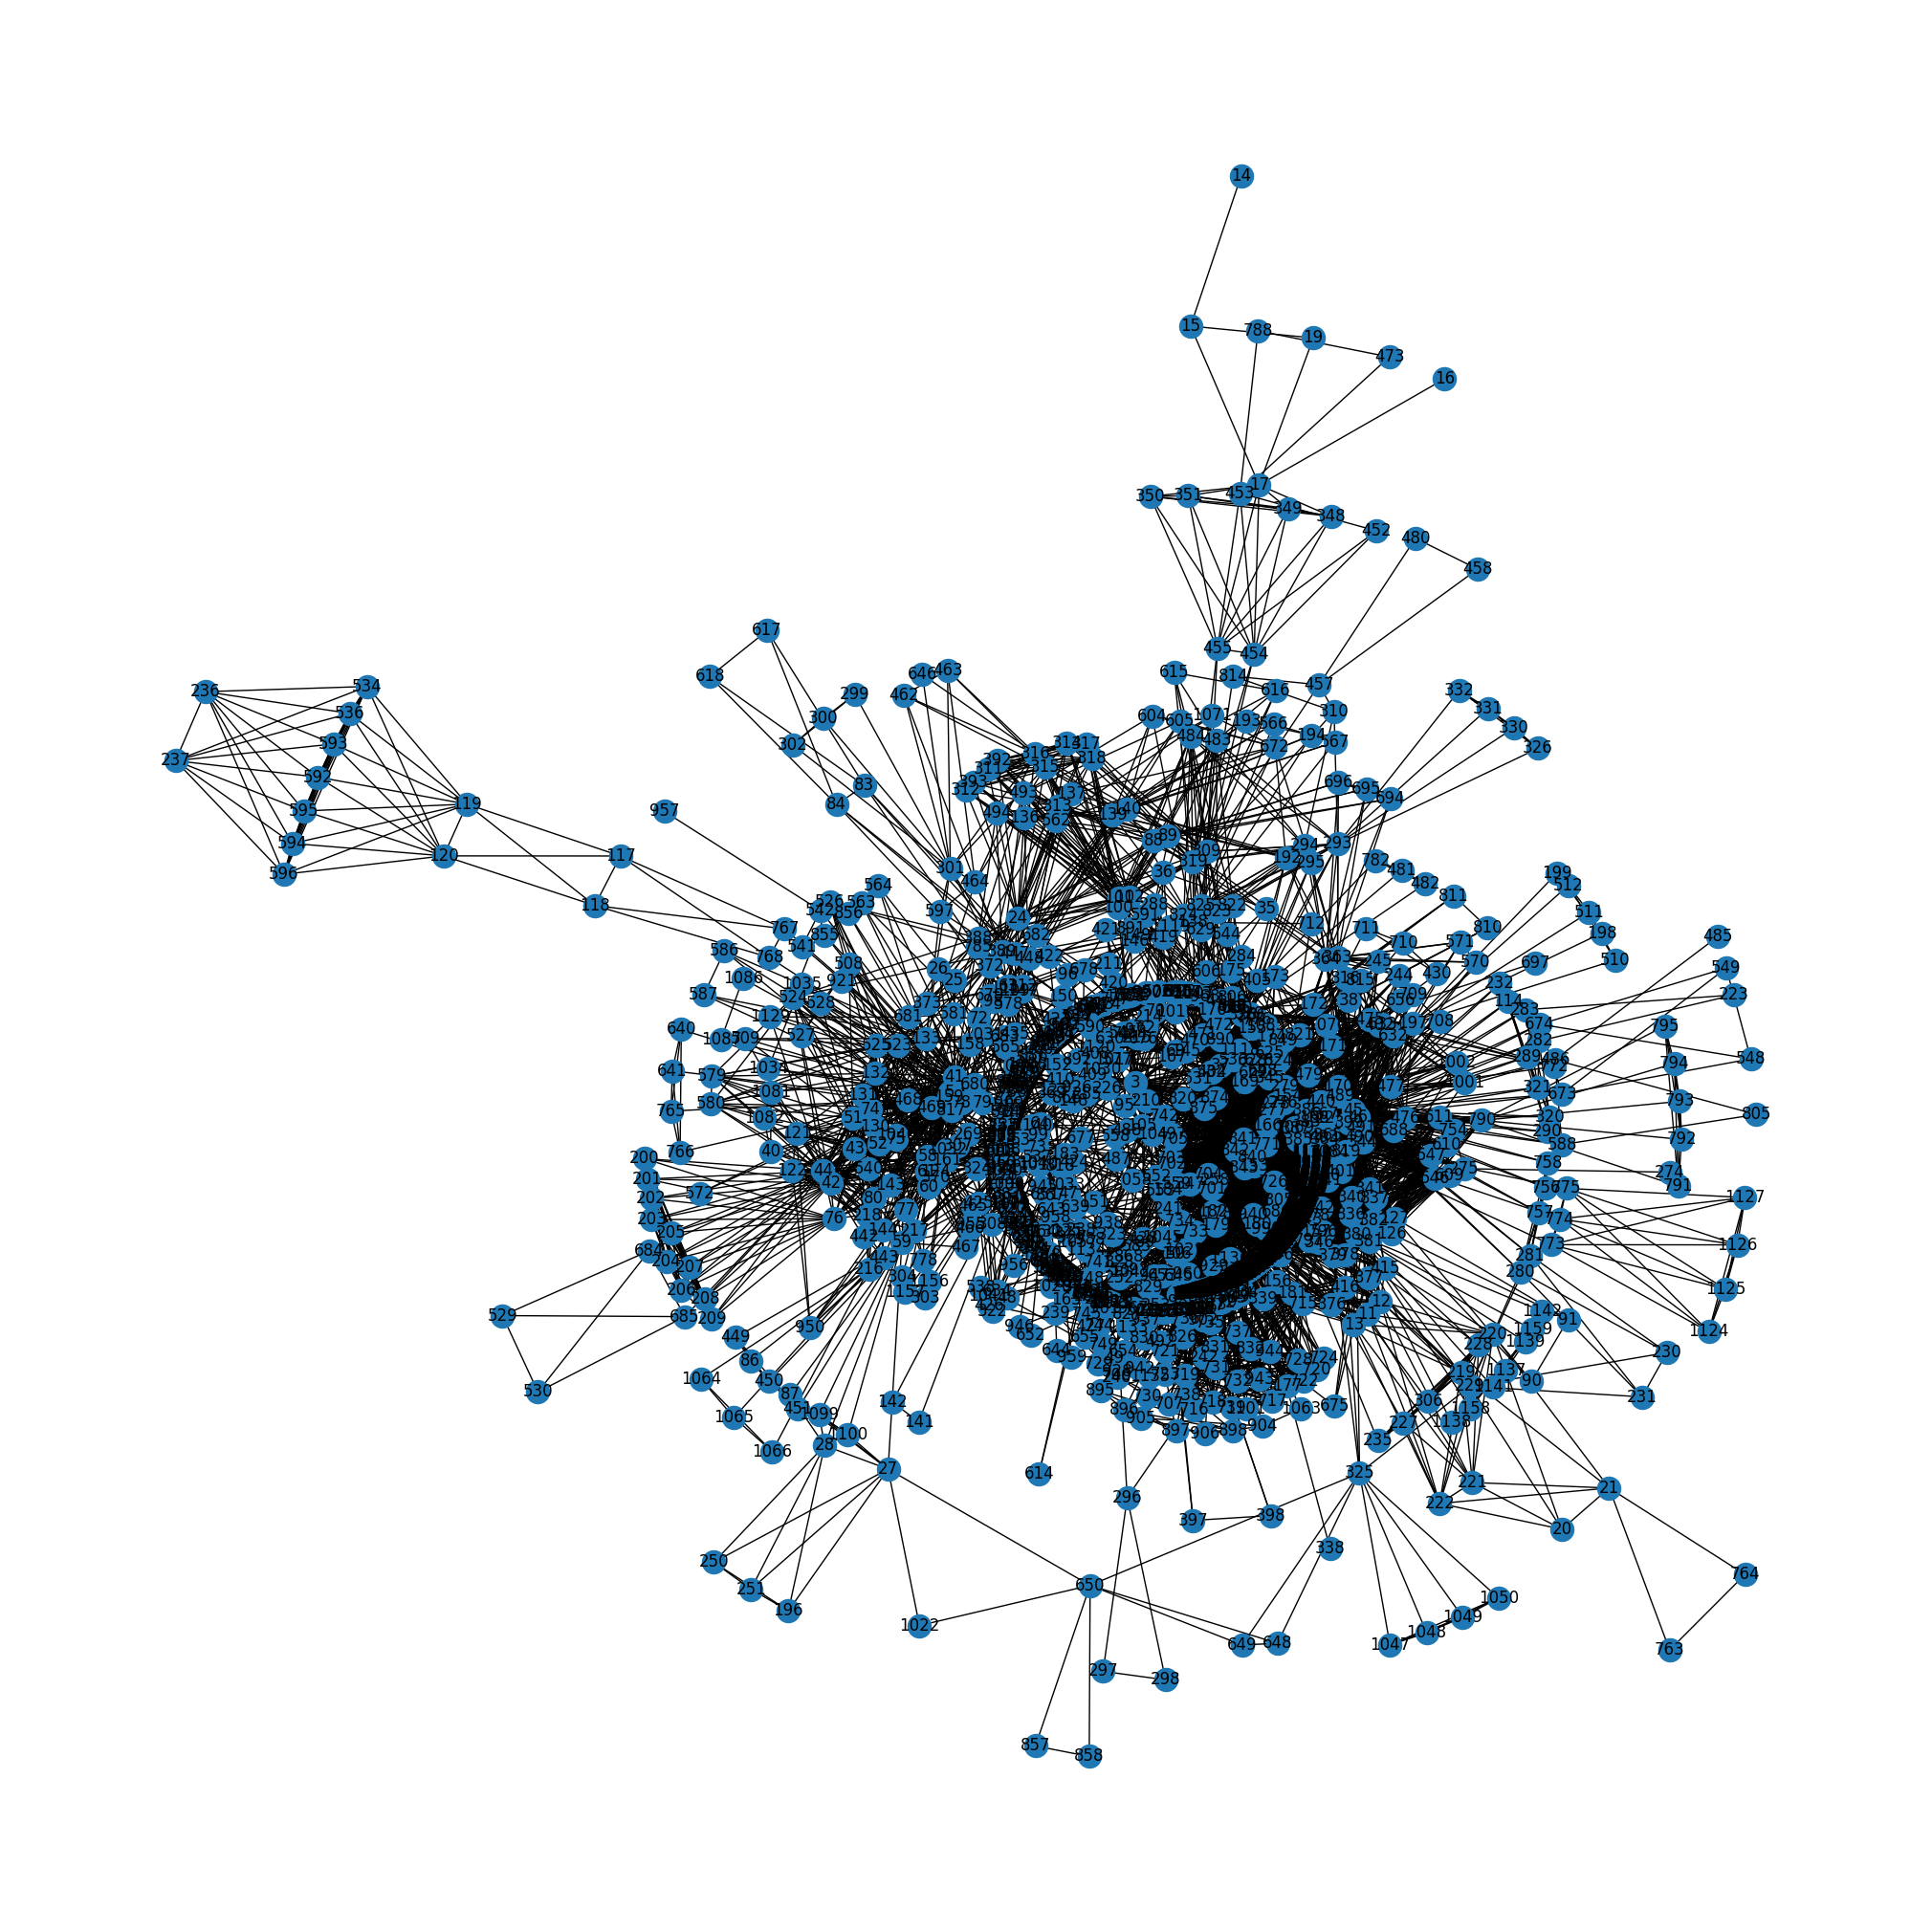

In [10]:
G = clique_expansion_transformation(train_positive_hyperlink_dict,nodes, True)

Create nodes index by order in G

In [11]:
G_nodes_mapping = {}
for i in G.nodes():
    G_nodes_mapping[i] = len(G_nodes_mapping)

Run network auralization - get signal to each node

In [12]:
signal = network_auralization_from_graph(G)

Pooling - mean nodes waveforms into hyperlinks

In [13]:
train_hyperlinks_waveforms = nodes_to_hyperlink(signal, train_hyperlink_dict, G_nodes_mapping)
test_hyperlinks_waveforms = nodes_to_hyperlink(signal, test_hyperlink_dict, G_nodes_mapping)

Train Classifier - M5 model

  0%|                                                                                           | 0/70 [00:00<?, ?it/s]C:\Users\Bar-Tov\Documents\Tamir\Studies\second grade\Thesis\CHESHIRE\cheshire-gapfilling\chesenv\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [09:25<00:00,  8.08s/it]


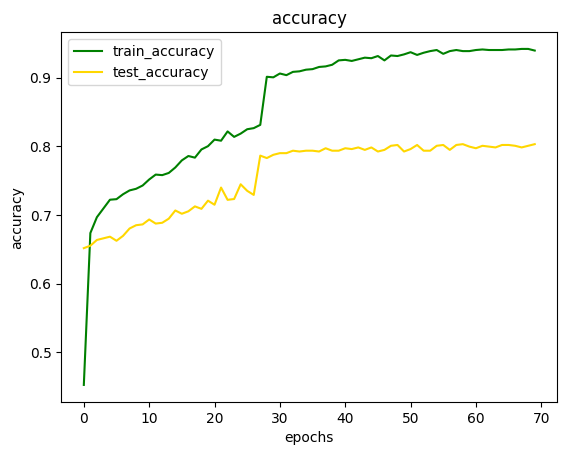

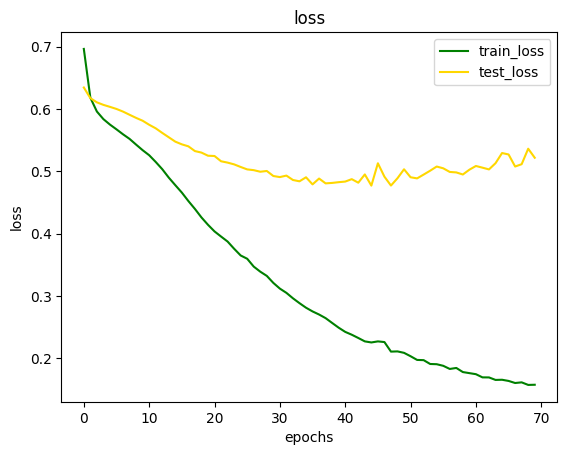

Max train accuracy: 0.9418789808917197
Max test accuracy: 0.8031026252983293


<Figure size 640x480 with 0 Axes>

In [14]:
y_pred = predict(train_hyperlinks_waveforms, y_train, test_hyperlinks_waveforms, y_test)